## Sentiment Analysis:

In [66]:
# necessary imports

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

## Dataset can be downloaded from: [kaggle](https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews/data)

In [67]:
# read the dataset stored locally
df = pd.read_csv("/content/drive/MyDrive/Reviews.csv")

In [68]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#Data Preprocessing

### Let's create a new column called "sentiment" based on the "score" column present

In [69]:
df["Score"].unique()

array([5, 1, 4, 2, 3])

In [70]:
def condition(row):
    if row["Score"] <= 3:
        return 0   # negative sentiment
    else:
        return 1   # positive sentiment

In [71]:
# apply the condition to the dataframe and store the result in a new column
df["Sentiment"] = df.apply(condition, axis = 1)

In [72]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,1


In [73]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'Sentiment'],
      dtype='object')

In [74]:
# filter the dataframe for required columns
df = df[["ProductId","Text", "Summary", "Sentiment"]]

In [75]:
# rename the columns in the dataframe
df.columns = ["ProductID","Review", "Summary" ,"Sentiment"]

In [76]:
# check for any NULL values within the ProductID column
df["ProductID"].isna().sum()

0

### Below, we see an imbalance in the two classes, so let's decrease the majority class to equal the minority.

In [77]:
df["Sentiment"].value_counts()

1    443777
0    124677
Name: Sentiment, dtype: int64

In [78]:
class_0_samples = df[df['Sentiment'] == 0]
class_1_samples = df[df['Sentiment'] == 1]

# Sample an equal number of samples from each class
num_samples =  df["Sentiment"].value_counts().min()
balanced_df = pd.concat([class_0_samples.sample(num_samples), class_1_samples.sample(num_samples)])

data = balanced_df.sample(frac=1).reset_index(drop=True)


### Although there are sohpisticated methods to perform data scaling and augmentation, I am using a naive approach here

In [79]:
data["Sentiment"].value_counts()

0    124677
1    124677
Name: Sentiment, dtype: int64

In [80]:
df.shape

(568454, 4)

In [81]:
# Perform data cleaning with the reviews. Often the data has unwanted tokens which do not contribute the performance of the model
# Hence it becomes necessary to handle such cases

import re

def clean_text(text):

    # Lowercasing
    text = text.lower()

    # remove HTML in the text
    soup = BeautifulSoup(text)
    text = soup.get_text()

    # Removing Punctuation
    text = re.sub(r'[^\w\s]', '', text)

    return text

In [82]:
df["Review"] = df["Review"].apply(clean_text)

<ipython-input-81-78989396edbd>:12: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text)


In [83]:
df.head()

,ProductID,Review,Summary,Sentiment
0,B001E4KFG0,i have bought several of the vitality canned d...,Good Quality Dog Food,1
1,B00813GRG4,product arrived labeled as jumbo salted peanut...,Not as Advertised,0
2,B000LQOCH0,this is a confection that has been around a fe...,"""Delight"" says it all",1
3,B000UA0QIQ,if you are looking for the secret ingredient i...,Cough Medicine,0
4,B006K2ZZ7K,great taffy at a great price there was a wide...,Great taffy,1


### Split the data into training and validation sets to feed into the model

In [84]:
data = list(df["Review"])
labels = list(df["Sentiment"])

In [85]:
training_size = int(len(data)* 0.75)

training_data = data[:training_size]
training_labels = labels[:training_size]

validation_data = data[training_size:]
validation_labels = labels[training_size:]

### Tokenize and pad the sequences so that the training data is consistent and ready to be loaded into the model

In [86]:
# import tokenizer

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [87]:
max_length = 400    # maximum length of each sentence
vocab_size = 2000   # maximum number of words that our text corpus would contain

In [88]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token = "<OOV>")  # instantiate tokenizer with default for out-of-vocabulary tokens

### Tokenize and pad the sequences. Finally convert them into numpy arrays

In [89]:
tokenizer.fit_on_texts(training_data)
training_data_sequences  = tokenizer.texts_to_sequences(training_data)
training_data_padded = pad_sequences(training_data_sequences,maxlen= max_length, padding = "post", truncating= "post" )

In [90]:
validation_data_sequences = tokenizer.texts_to_sequences(validation_data)
validation_data_padded = pad_sequences(validation_data_sequences,maxlen= max_length, padding = "post", truncating= "post" )

In [91]:
training_labels = np.array(training_labels)
validation_labels = np.array(validation_labels)

## Creating the model

In [92]:
embedding_dim = 16   # dimension for word_embedding
BATCH_SIZE = 128

In [121]:
model = tf.keras.Sequential([

        # input to the embedding layer is one whole sentence at a time. Shape: (None, 500)
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),

        # input to LSTM layers is a (2D Numpy array) of 500 word tokens each having an embedding dimension of 16, Shape: (None, 500, 16)
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8)),

        tf.keras.layers.Dense(8, activation = "relu"),

        # output layer
        tf.keras.layers.Dense(1, activation = "sigmoid")
])

In [122]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 400, 16)           32000     
                                                                 
 bidirectional_2 (Bidirecti  (None, 16)                1600      
 onal)                                                           
                                                                 
 dense_5 (Dense)             (None, 8)                 136       
                                                                 
 dense_6 (Dense)             (None, 1)                 9         
                                                                 
Total params: 33745 (131.82 KB)
Trainable params: 33745 (131.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [123]:
# compile the model
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), loss = "binary_crossentropy", metrics = ["accuracy"],)

In [124]:
epochs = 10
model.fit(training_data_padded, training_labels, epochs=epochs,
          validation_data=(validation_data_padded, validation_labels),
          batch_size = BATCH_SIZE,
          shuffle = True,)

Epoch 1/10
3331/3331 [==============================] - 153s 45ms/step - loss: 0.4039 - accuracy: 0.8224 - val_loss: 0.3052 - val_accuracy: 0.8703
Epoch 2/10
3331/3331 [==============================] - 115s 34ms/step - loss: 0.2947 - accuracy: 0.8755 - val_loss: 0.2867 - val_accuracy: 0.8815
Epoch 3/10
3331/3331 [==============================] - 122s 37ms/step - loss: 0.2838 - accuracy: 0.8814 - val_loss: 0.2831 - val_accuracy: 0.8824
Epoch 4/10
3331/3331 [==============================] - 121s 36ms/step - loss: 0.2795 - accuracy: 0.8843 - val_loss: 0.2774 - val_accuracy: 0.8849
Epoch 5/10
3331/3331 [==============================] - 121s 36ms/step - loss: 0.2763 - accuracy: 0.8857 - val_loss: 0.2752 - val_accuracy: 0.8870
Epoch 6/10
3331/3331 [==============================] - 113s 34ms/step - loss: 0.2742 - accuracy: 0.8865 - val_loss: 0.2734 - val_accuracy: 0.8869
Epoch 7/10
3331/3331 [==============================] - 112s 34ms/step - loss: 0.2718 - accuracy: 0.8872 - val_loss: 0

In [97]:
model.history

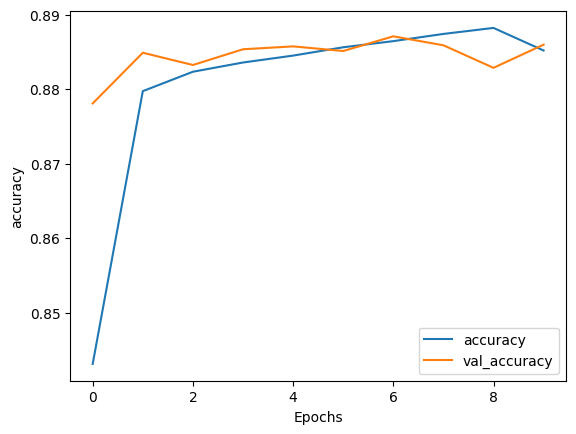

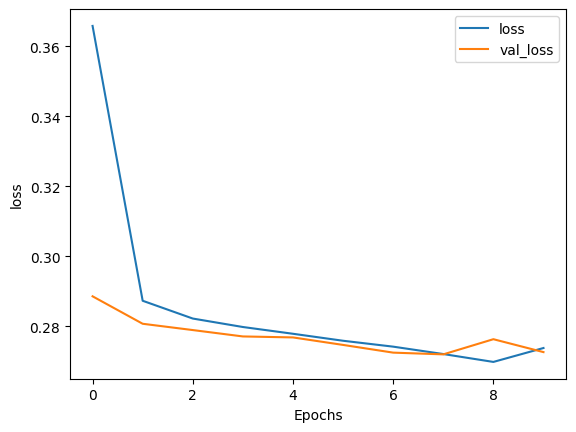

In [98]:
# plot the training and validation accuracy and losses using a simple function

def plot_graphs(string):
  plt.plot(model.history.history[string])
  plt.plot(model.history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs("accuracy")
plot_graphs("loss")

In [99]:
# Tricky test samples

test_review = ["lovely", "dreadful", "stay away",
             "everything was hot exactly as I wanted",
             "everything was not exactly as I wanted",
             "they gave us free chocolate cake",
             "I've never eaten anything so spicy in my life, my throat burned for hours",
             "for a phone that is as expensive as this one I expect it to be much easier to use than this thing is",
             "we left there very full for a low price so I'd say you just can't go wrong at this place",
             "that place does not have quality meals and it isn't a good place to go for dinner",
             ]

In [100]:
samples = tokenizer.texts_to_sequences(test_review)
padded_samples = pad_sequences(samples,maxlen= max_length, padding = "post", truncating = "post")

In [101]:
model.predict(padded_samples)

1/1 [==============================] - 1s 671ms/step


array([[0.8707719 ],
       [0.6981051 ],
       [0.59037423],
       [0.8862177 ],
       [0.7722478 ],
       [0.7457155 ],
       [0.8277771 ],
       [0.928615  ],
       [0.914865  ],
       [0.9037451 ]], dtype=float32)

In [102]:
# Saving the model to save the architecture, optimizer and learned weights
model.save('sentiment_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Below code is taken from Tensorflow.org. The code helps us visualize the word embeddings in a 3D space. Find the visualizer here: [embedding_projector](https://projector.tensorflow.org/)

In [118]:
# First get the weights of the embedding layer
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(2000, 16)


In [119]:
import io

# Write out the embedding vectors and metadata
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [120]:
# Download the files
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vectors.tsv')
  files.download('metadata.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>